## 파이프라인 파악 및 설계 7/15 - 7/17 (목)

# 경구약제 이미지 객체 검출(Object Detection) 프로젝트

##1. 데이터 전처리 및 시스템 구축



1.   파일 구조 및 데이터 확인
2.   EDA 해서 전처리 필요 항목 특정하기
3.   EDA 결과 토대로 전처리 작업하기
4.   데이터 증강 기법으로 데이터 셋 확장, 데이터 파이프라인 구축하기(심화)




##1) 파일 구조 및 데이터 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

project_path = '/content/drive/MyDrive/초급 프로젝트 데이터 모음'
os.chdir(project_path)

print("현재 디렉토리:", os.getcwd())


현재 디렉토리: /content/drive/MyDrive/초급 프로젝트 데이터 모음


Train image 샘플 출력

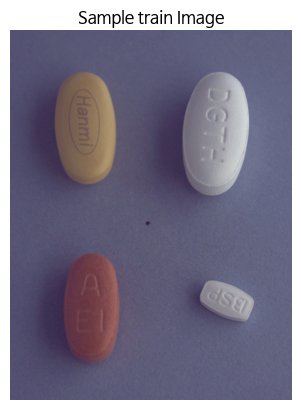

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = './train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.png'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title("Sample train Image")
plt.show()


 전체 폴더 구조 확인

In [ ]:
import os

folders = {
    "Train Images": "./train_images",
    "Train Annotations": "./train_annotations",
    "Test Images": "./test_images"
}

for name, path in folders.items():
    print(f"\n [{name}] - 경로: {path}")
    if os.path.exists(path):
        items = os.listdir(path)
        print(f"총 {len(items)}개 항목이 있습니다.")
        print("샘플:")
        for item in items[:5]:  # 최대 5개까지만 출력
            print(f"  └── {item}")
    else:
        print("해당 폴더가 존재하지 않습니다.")



 [Train Images] - 경로: ./train_images
총 1489개 항목이 있습니다.
샘플:
  └── K-003351-003832-035206_0_2_0_2_70_000_200.png
  └── K-003351-013900-035206_0_2_0_2_75_000_200.png
  └── K-003351-013900-036637_0_2_0_2_75_000_200.png
  └── K-003351-016232-018357_0_2_0_2_75_000_200.png
  └── K-003351-013900-038162_0_2_0_2_75_000_200.png

 [Train Annotations] - 경로: ./train_annotations
총 498개 항목이 있습니다.
샘플:
  └── K-001900-010224-016551-031705_json
  └── K-001900-010224-016551-033009_json
  └── K-001900-016548-018110-021026_json
  └── K-001900-016548-018110-027926_json
  └── K-001900-016548-018110-029345_json

 [Test Images] - 경로: ./test_images
총 843개 항목이 있습니다.
샘플:
  └── 1007.png
  └── 1006.png
  └── 1004.png
  └── 100.png
  └── 1003.png


* train image : 1489개
* train annotations : 498개
* test images : 843개

한글 폰트 불러오기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)



Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped direc

##annotation 폴더 내부 json 구조 확인

In [ ]:
import os
import json

ann_root = './train_annotations'
ann_folders = sorted(os.listdir(ann_root))

# 어노테이션 폴더 하나 선택
for ann_folder in ann_folders:
    outer_folder_path = os.path.join(ann_root, ann_folder)
    if not os.path.isdir(outer_folder_path):
        continue

    inner_items = os.listdir(outer_folder_path)

    # 내부 디렉토리 탐색 (예: K-001900)
    for inner_name in inner_items:
        inner_path = os.path.join(outer_folder_path, inner_name)

        if os.path.isdir(inner_path):
            json_like_files = os.listdir(inner_path)

            if json_like_files:
                sample_path = os.path.join(inner_path, json_like_files[0])
                print(f"json 파일(sample): {sample_path}")

                # JSON 읽기 시도
                try:
                    with open(sample_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    print("\n json 구조:")
                    for key, value in data.items():
                        preview = str(value)
                        if isinstance(value, (list, dict)):
                            preview = preview[:300] + '...' if len(preview) > 300 else preview
                        print(f" - {key}: {preview}")
                    break  # 첫 번째 성공한 파일만 확인
                except Exception as e:
                    print(f"json 파싱 실패: {e}")
                    continue
    else:
        continue
    break


json 파일(sample): ./train_annotations/K-001900-010224-016551-031705_json/K-001900/K-001900-010224-016551-031705_0_2_0_2_75_000_200.json

 json 구조:
 - images: [{'file_name': 'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png', 'width': 976, 'height': 1280, 'imgfile': 'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png', 'drug_N': 'K-001900', 'drug_S': '정상알약', 'back_color': '연회색 배경', 'drug_dir': '앞면', 'light_color': '주백색', 'camera_la': 75, 'camera_lo'...
 - type: instances
 - annotations: [{'area': 29008, 'iscrowd': 0, 'bbox': [128, 258, 196, 148], 'category_id': 1899, 'ignore': 0, 'segmentation': [], 'id': 5395, 'image_id': 1418}]
 - categories: [{'supercategory': 'pill', 'id': 1899, 'name': '보령부스파정 5mg'}]


| 키             | 내용                                        |
| ------------- | ----------------------------------------- |
| `images`      | 이미지 정보 (파일명, 크기, 부가 설명 등 포함)              |
| `type`        | COCO 형식 명시 (`instances`)                  |
| `annotations` | 바운딩 박스 정보: `bbox = [x, y, width, height]` |
| `categories`  | 클래스 정보: `category_id → class name` 매핑     |





*  COCO format 기반 커스텀 구조 (파일 하나에 모든 이미지에 대한 정보 담음)




##2)Exploratory Data Analysis(EDA) 후 데이터 전처리

* 이미지 크기 확인(width, height 분포 확인)
* 해상도 차이 확인(이미지 width.height 분포, 해상도 종류,리사이징 기준 설정)
* 색감 차이 확인(배경 노이즈 조절, 밝기 정규화, 색상 보정)
* 클래스 별 객체수 bar chart 확인(약 종류 확인)(oversampling/undersampling)
* 라벨 품질 확인 (총 이미지 수, 라벨 없는 이미지 수, 중복 이미지/라벨 확인)
* 바운딩 박스 확인(bbox 면적, 개수, 비율, 바운딩 박스 중심 좌표 시각화(heatmap) , 이미지 밖 여부, w/h 비율 분석, 이미지 한 장당 객체 몇개인지 파악)
=> 클래스 - 객체 수 5-10개만 시각화 해보기

1.이미지 크기 확인(width, height 분포 확인)

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 폴더 경로
img_dir = './train_images'

# 이미지 크기 저장 리스트
widths = []
heights = []

# 이미지 파일 순회
for filename in os.listdir(img_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(img_dir, filename)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except Exception as e:
            print(f" 에러 발생: {filename} → {e}")

In [ ]:
# 통계 출력
print(f"\n 이미지 수: {len(widths)}")
print(f"가장 작은 이미지: {min(widths)}x{min(heights)}")
print(f"가장 큰 이미지: {max(widths)}x{max(heights)}")


 이미지 수: 1489
가장 작은 이미지: 976x1280
가장 큰 이미지: 976x1280


=>리사이징 전처리 할 거 없음

2. 해상도 차이 확인(width.height 분포, 해상도 종류,리사이징 기준 설정)

In [ ]:
import os
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

# 이미지 폴더 경로
img_dir = './train_images'

# 해상도 (width, height) 종류 파악
resolutions = []

image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for i, filename in enumerate(image_files):
    img_path = os.path.join(img_dir, filename)
    try:
        with Image.open(img_path) as img:
            resolutions.append((img.width, img.height))
    except Exception as e:
        print(f"{filename} 에러: {e}")

# 해상도별 빈도 수 계산 (얼마나 많은 이미지가 같은 해상도 쓰는지)
resolution_counts = Counter(resolutions)

# 정렬해서 보기 좋게
sorted_resolutions = sorted(resolution_counts.items(), key=lambda x: x[1], reverse=True)

# 출력
print(f"\n 해상도 종류 수: {len(resolution_counts)}")
print(" 가장 많이 쓰인 해상도:")
for res, count in sorted_resolutions[:5]:
    print(f"  - {res[0]}x{res[1]}: {count}개")


 해상도 종류 수: 1
 가장 많이 쓰인 해상도:
  - 976x1280: 1489개


=> 리사이징 할 필요 없음!

3. 색감 차이 확인(배경 노이즈 조절, 밝기 정규화, 색상 보정)

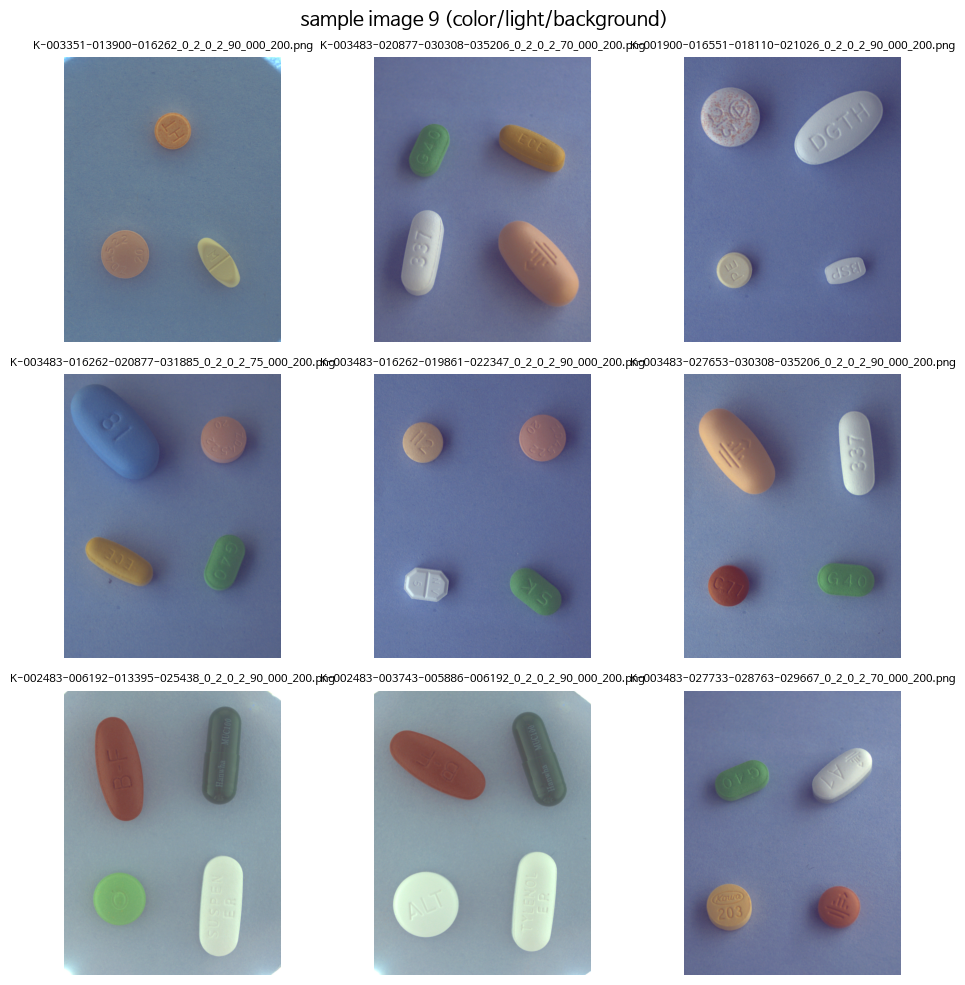

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 폴더
img_dir = './train_images'

# 샘플 9장 무작위 추출
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_files = random.sample(image_files, 9)

# 시각화
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img_path = os.path.join(img_dir, sample_files[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(sample_files[i], fontsize=8)
    ax.axis('off')

plt.suptitle(" sample image 9 (color/light/background)", fontsize=14)
plt.tight_layout()
plt.show()


1. 밝기 => 이미지마다 밝기 차이 있음
2. 색감 => 밝기 차이에 따라 색감이 다름, 약 색 혼동할 가능성 존재
3. 배경색 => 하늘/파랑 두가지 색상 정규화/배경제거 하기
* 노이즈는 딱히 없음.

1. 밝기 정규화

2. 색상 보정

3. 배경 마스킹

4.클래스 별 객체수 bar chart 확인(약 종류 확인)(oversampling/undersampling)

다 봐야할지 일부만 봐도 ㄱㅊ을 지 고민

In [ ]:
# JSON 경로 수집 - 올바른 .json 파일만 필터링
json_paths = []

for folder in os.listdir(ann_root):
    folder_path = os.path.join(ann_root, folder)
    if not os.path.isdir(folder_path):
        continue

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        for file in os.listdir(subfolder_path):
            full_path = os.path.join(subfolder_path, file)
            # 실제 파일이고 .json 확장자인 경우만 추가
            if os.path.isfile(full_path) and file.endswith('.json'):
                json_paths.append(full_path)

print(f"실제 .json 파일 수: {len(json_paths)}개")


실제 .json 파일 수: 4526개


In [ ]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

ann_root = './train_annotations'
category_count = defaultdict(int)
category_id_to_name = {}

# JSON 경로 수집
json_paths = []
for folder in os.listdir(ann_root):
    folder_path = os.path.join(ann_root, folder)
    if not os.path.isdir(folder_path):
        continue

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        for file in os.listdir(subfolder_path):
            if file.endswith('.json'):
                json_paths.append(os.path.join(subfolder_path, file))


# 병렬로 처리할 함수
def process_json(json_path):
    local_category_count = defaultdict(int)
    local_category_name = {}

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for cat in data.get('categories', []):
                local_category_name[cat['id']] = cat['name']
            for ann in data.get('annotations', []):
                local_category_count[ann['category_id']] += 1
    except:
        pass

    return local_category_count, local_category_name


# 병렬 처리 실행
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_json, path) for path in json_paths]

    for i, future in enumerate(as_completed(futures)):
        local_counts, local_names = future.result()
        for k, v in local_counts.items():
            category_count[k] += v
        for k, v in local_names.items():
            category_id_to_name[k] = v
        if i % 50 == 0:
            print(f"{i}/{len(json_paths)}개 파일 처리 완료")


0/4526개 파일 처리 완료
50/4526개 파일 처리 완료
100/4526개 파일 처리 완료
150/4526개 파일 처리 완료
200/4526개 파일 처리 완료
250/4526개 파일 처리 완료
300/4526개 파일 처리 완료
350/4526개 파일 처리 완료
400/4526개 파일 처리 완료
450/4526개 파일 처리 완료
500/4526개 파일 처리 완료
550/4526개 파일 처리 완료
600/4526개 파일 처리 완료
650/4526개 파일 처리 완료
700/4526개 파일 처리 완료
750/4526개 파일 처리 완료
800/4526개 파일 처리 완료
850/4526개 파일 처리 완료
900/4526개 파일 처리 완료
950/4526개 파일 처리 완료
1000/4526개 파일 처리 완료
1050/4526개 파일 처리 완료
1100/4526개 파일 처리 완료
1150/4526개 파일 처리 완료
1200/4526개 파일 처리 완료
1250/4526개 파일 처리 완료
1300/4526개 파일 처리 완료
1350/4526개 파일 처리 완료
1400/4526개 파일 처리 완료
1450/4526개 파일 처리 완료
1500/4526개 파일 처리 완료
1550/4526개 파일 처리 완료
1600/4526개 파일 처리 완료
1650/4526개 파일 처리 완료
1700/4526개 파일 처리 완료
1750/4526개 파일 처리 완료
1800/4526개 파일 처리 완료
1850/4526개 파일 처리 완료
1900/4526개 파일 처리 완료
1950/4526개 파일 처리 완료
2000/4526개 파일 처리 완료
2050/4526개 파일 처리 완료
2100/4526개 파일 처리 완료
2150/4526개 파일 처리 완료
2200/4526개 파일 처리 완료
2250/4526개 파일 처리 완료
2300/4526개 파일 처리 완료
2350/4526개 파일 처리 완료
2400/4526개 파일 처리 완료
2450/4526개 파일 처리 완료
2500/4526개 파일 처리 완료
255

26개 파일 행방 찾기

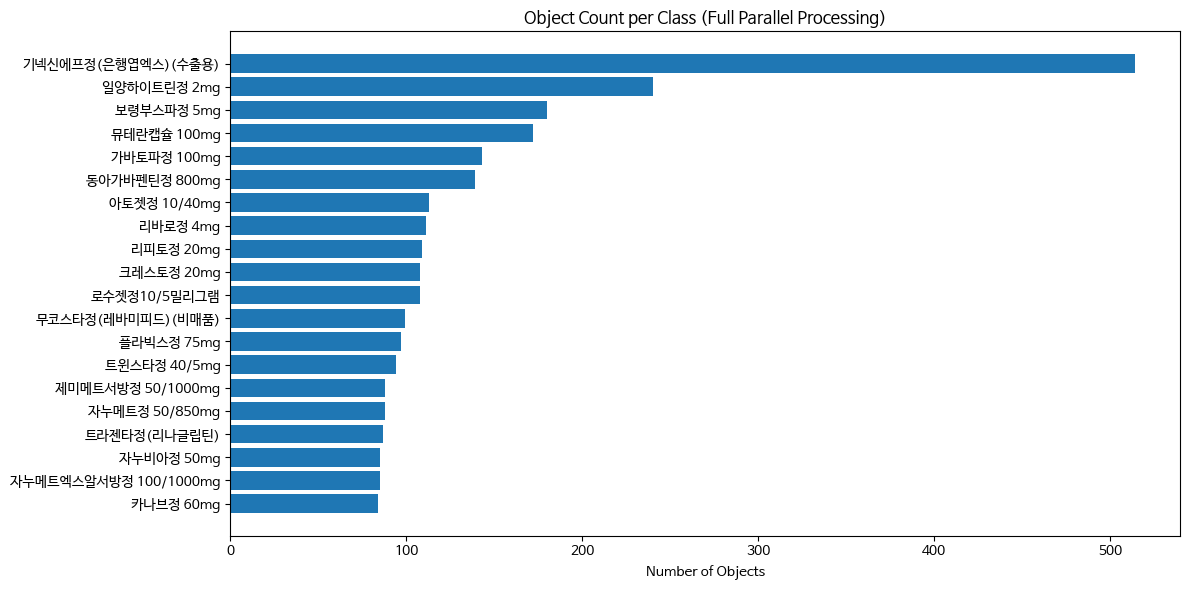


Total Number of Processed JSON Files: 4526
Number of Unique Classes Detected: 73


In [ ]:
# 상위 클래스 시각화
sorted_items = sorted(category_count.items(), key=lambda x: x[1], reverse=True)[:20]
labels = [category_id_to_name.get(cid, str(cid)) for cid, _ in sorted_items]
values = [count for _, count in sorted_items]

plt.figure(figsize=(12, 6))
plt.barh(labels, values)
plt.xlabel("Number of Objects") #객체 수
plt.title("Object Count per Class (Full Parallel Processing)") #클래스별 객체 수 (전체 병렬 처리)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTotal Number of Processed JSON Files: {len(json_paths)}") #전체 처리한 JSON 파일 수
print(f"Number of Unique Classes Detected: {len(category_count)}")# 발견된 클래스 수

총 클래스 수 : 73개(약종류)

In [ ]:
# 약 종류(class) 총 수
total_classes = len(category_count)

#약 종류별 객체 수
sorted_class_stats = sorted(category_count.items(), key=lambda x: x[1], reverse=True)

print(f"Total Number of Unique Drug Classes: {total_classes}\n")

print("Object Count per Drug Class:")
for cid, count in sorted_class_stats:
    class_name = category_id_to_name.get(cid, f"(unknown id {cid})")
    print(f"- {class_name}: {count} objects")


Total Number of Unique Drug Classes: 73

Object Count per Drug Class:
- 기넥신에프정(은행엽엑스)(수출용): 514 objects
- 일양하이트린정 2mg: 240 objects
- 보령부스파정 5mg: 180 objects
- 뮤테란캡슐 100mg: 172 objects
- 가바토파정 100mg: 143 objects
- 동아가바펜틴정 800mg: 139 objects
- 아토젯정 10/40mg: 113 objects
- 리바로정 4mg: 111 objects
- 리피토정 20mg: 109 objects
- 크레스토정 20mg: 108 objects
- 로수젯정10/5밀리그램: 108 objects
- 무코스타정(레바미피드)(비매품): 99 objects
- 플라빅스정 75mg: 97 objects
- 트윈스타정 40/5mg: 94 objects
- 제미메트서방정 50/1000mg: 88 objects
- 자누메트정 50/850mg: 88 objects
- 트라젠타정(리나글립틴): 87 objects
- 자누비아정 50mg: 85 objects
- 자누메트엑스알서방정 100/1000mg: 85 objects
- 카나브정 60mg: 84 objects
- 트라젠타듀오정 2.5/850mg: 81 objects
- 엑스포지정 5/160mg: 80 objects
- 세비카정 10/40mg: 79 objects
- 아모잘탄정 5/100mg: 76 objects
- 노바스크정 5mg: 66 objects
- 큐시드정 31.5mg/PTP: 61 objects
- 삼남건조수산화알루미늄겔정: 56 objects
- 알드린정: 54 objects
- 트루비타정 60mg/병: 39 objects
- 울트라셋이알서방정: 38 objects
- 비모보정 500/20mg: 38 objects
- 비타비백정 100mg/병: 38 objects
- 다보타민큐정 10mg/병: 36 objects
- 메가파워정 90mg/병: 36 ob

* 브린텔릭스정 20mg: 7 objects
* 기넥신에프정(은행엽엑스)(수출용): 514 objects
=> 약 70배 차이, 클래스 불균형

데이터 보정 필요.
* oversampling
* undersampling
* 데이터 제거
고민


5. 라벨 품질 확인 (총 이미지 수, 라벨 없는 이미지 수, 중복 이미지/라벨 확인)

In [ ]:
import os
import json
from collections import defaultdict

# 경로 설정
img_dir = './train_images'
ann_dir = './train_annotations'

# 전체 이미지 파일 리스트
img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_set = set(img_files)

# 어노테이션 내부 모든 JSON 읽어서 이미지 목록 추출
json_image_set = set()
annotation_count = 0
image_to_ann_count = defaultdict(int)

# 모든 annotation 폴더 탐색
for folder in os.listdir(ann_dir):
    folder_path = os.path.join(ann_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for drug_folder in os.listdir(folder_path):
        drug_path = os.path.join(folder_path, drug_folder)
        if not os.path.isdir(drug_path):
            continue
        for file in os.listdir(drug_path):
            if file.endswith('.json'):
                annotation_count += 1
                json_path = os.path.join(drug_path, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                        for img in data.get('images', []):
                            img_name = img['file_name']
                            json_image_set.add(img_name)
                            image_to_ann_count[img_name] += 1
                except Exception as e:
                    print(f"JSON 파일 오류: {json_path} - {e}")

# 라벨 없는 이미지
unlabeled_images = img_set - json_image_set

# 중복 어노테이션 확인 (같은 이미지가 여러 JSON에 중복될 경우)
duplicate_labeled_images = [k for k, v in image_to_ann_count.items() if v > 1]

# 통계 출력
print(f"Total images in train_images/: {len(img_files)}")
print(f" Total images with annotations: {len(json_image_set)}")
print(f" Images without annotations: {len(unlabeled_images)}")
print(f"Images with duplicate annotations: {len(duplicate_labeled_images)}")

# 예시 출력
if unlabeled_images:
    print("\n Sample unlabeled images:")
    for img in list(unlabeled_images)[:5]:
        print(f"- {img}")

if duplicate_labeled_images:
    print("\nSample duplicate-labeled images:")
    for img in duplicate_labeled_images[:5]:
        print(f"- {img} (count: {image_to_ann_count[img]})")


Total images in train_images/: 1489
 Total images with annotations: 1489
 Images without annotations: 0
Images with duplicate annotations: 1425

Sample duplicate-labeled images:
- K-001900-010224-016551-031705_0_2_0_2_75_000_200.png (count: 2)
- K-001900-010224-016551-031705_0_2_0_2_70_000_200.png (count: 3)
- K-001900-010224-016551-031705_0_2_0_2_90_000_200.png (count: 3)
- K-001900-010224-016551-033009_0_2_0_2_70_000_200.png (count: 2)
- K-001900-010224-016551-033009_0_2_0_2_90_000_200.png (count: 3)


* 모든 이미지에 라벨 존재
* 총 1489개 이미지 중 1425개가 여러 JSON 파일에 중복 => 중복 이미지만 뽑아서 시각화, 중복 제거 or 통합 결정

6. 바운딩 박스 확인(바운딩 박스 중심 좌표 시각화(heatmap) , 이미지 밖 여부, w/h 비율 분석, 이미지 한 장당 객체 몇개인지 파악) => 클래스 - 객체 수 5-10개만 시각화 해보기

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 어노테이션 루트 폴더
ANNOT_ROOT = '/content/drive/Othercomputers/내 노트북/train_annotations'

# 중심 좌표 저장
center_points = []

# JSON 파일 탐색
for folder_name in tqdm(os.listdir(ANNOT_ROOT)):
    folder_path = os.path.join(ANNOT_ROOT, folder_name)

    if not os.path.isdir(folder_path):
        continue

    for root, _, files in os.walk(folder_path):
        for file in files:
            if not file.endswith('.json'):
                continue

            json_path = os.path.join(root, file)

            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                if 'annotations' in data and 'images' in data:
                    width = data['images'][0]['width']
                    height = data['images'][0]['height']

                    for ann in data['annotations']:
                        x, y, w, h = ann['bbox']
                        cx = x + w / 2
                        cy = y + h / 2
                        # 정규화
                        cx_norm = cx / width
                        cy_norm = cy / height
                        center_points.append([cx_norm, cy_norm])
            except:
                continue


100%|██████████| 498/498 [00:17<00:00, 28.67it/s]


속도 느림

In [ ]:
# 시각화
if center_points:
    center_points = np.array(center_points)

    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        x=center_points[:, 0],
        y=center_points[:, 1],
        cmap="Reds",
        shade=True,
        bw_adjust=0.5,
        cbar=True,
    )
    plt.title("Bounding Box Center Heatmap (Normalized)")
    plt.xlabel("Normalized X Center")
    plt.ylabel("Normalized Y Center")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("바운딩 박스 데이터가 없습니다.")

* 좌상단에 몰림=> 이동 고려
* YOLO Anchor Box 추출에 참고

이미지 밖 여부

w/h 비율 분석

이미지 한 장당 객체 몇개인지 파악

##3)EDA 결과 토대로 전처리 작업 (노이즈 제거, 크기 조정, 색상 보정)

학습 위한 형식으로 변환

##2. 경구약제 이미지 인식 모델 개발
딥러닝 모델 설계, 아키텍처 결정

###바운딩 박스, 객체 감지 해야하므로 Yolo계열 모델 사용

1.  CNN 기반의 VggNet, ResNet, 객체 인식을 위한 YOLO 등의 다양한 모델을 설계하고, 실제로 구현
2.  각 모델에 대해 초기 학습 및 성능 평가를 시행하고, 모델별 성능 지표(정확도, 정밀도, 재현율 등)을 비교하여 최적의 모델을 선택

YOLO/CNN 모델 비교 -> 어떻게 쓸 지 결정

 YOLO 학습용 데이터 → YOLO format으로 변환

 YOLOv5 or YOLOv8 학습 진행 (mAP / inference time / 모델 크기 등 비교)

 YOLO inference로 나온 bbox로 crop 이미지 생성

 crop 이미지로 CNN classifier 학습 (ResNet 등)

 두 모델 성능 비교 (confusion matrix, accuracy 등)



1) YOLO계열
: 객체 탐지, 분류 학습
* 전체 이미지에서 약을 탐지 + 분류
* mAP, 정확도, recall, precision 측정

2)CNN 계열
: 알약 이미지 평가/비교
* YOLO나 어노테이션으로 crop된 알약 이미지 사용
* 분류 정확도 (accuracy) 중심으로 측정



YOLOv5와 YOLOv8 모델을 각각 학습  mAP, FPS, 모델 크기 등을 비교하여 YOLO 계열 내에서도 최적 모델 선정

클래스 간 불균형 문제=> 클래스별 oversampling 및 데이터 증강 전처리 후  일부 클래스에 적용하기

CNN 기반 분류기 학습 시 YOLO 추론 결과로 생성된 crop 이미지를 이용, 정확도와 confusion matrix를 중심으로 성능을 평가하기

결과 분석 시 YOLO bbox 시각화, CNN confusion matrix heatmap 등을 통해 비교하기

성능보고 YOLO/ YOLO+CNN 결정

In [ ]:
#기초 라이브러리 임포트
import os
import glob
import random
import json
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import torch
from yolov5.utils.general import check_img_size
from yolov5.models.common import DetectMultiBackend


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


##3. 데이터 시각화 및 모델 성능 결과 도출
실험, 하이퍼 파라미터 튜닝 및 모델 성능 평가
모델을 사용하여 경구약제 이미지를 인식하고, 그 결과를 시각적으로 확인

In [ ]:
# Colab에서 GitHub 저장소를 클론
!git clone https://github.com/soohyun-chris-jeon/AI03-Project-1.git

Cloning into 'AI03-Project-1'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 90 (delta 32), reused 54 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 49.71 KiB | 771.00 KiB/s, done.
Resolving deltas: 100% (32/32), done.
